In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [2]:
df_movies = pd.read_csv('datasets/classifiedMovies.txt', sep="\t", header=None, low_memory=False)

In [3]:
df_movies.columns = ["message",	"originalClassification","scoreP","scoreZ","polarity",	"termsP",	"termsN"]

In [4]:
df = df_movies

In [5]:
df['message_len'] = df['message'].astype(str).apply(len)

In [6]:
df.shape

(31986, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31986 entries, 0 to 31985
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   message                 31986 non-null  object 
 1   originalClassification  31986 non-null  object 
 2   scoreP                  31986 non-null  float64
 3   scoreZ                  31986 non-null  float64
 4   polarity                31986 non-null  object 
 5   termsP                  5079 non-null   object 
 6   termsN                  987 non-null    object 
 7   message_len             31986 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 2.0+ MB


In [8]:
df.polarity.value_counts()

Inconclusive        26108
Positive Extreme     5596
Negative Extreme      282
Name: polarity, dtype: int64

In [9]:
df.describe()

,scoreP,scoreZ,message_len
count,31986.000000,31986.000000,31986.000000
mean,0.156898,-0.010022,114.189645
std,0.375649,0.172811,51.198618
min,0.000000,-1.930000,4.000000
25%,0.000000,0.000000,76.000000
50%,0.000000,0.000000,111.000000
75%,0.000000,0.000000,149.000000
max,2.810000,1.930000,268.000000


In [10]:
df["message_len"].describe().apply(lambda x: format(x, 'f'))

count    31986.000000
mean       114.189645
std         51.198618
min          4.000000
25%         76.000000
50%        111.000000
75%        149.000000
max        268.000000
Name: message_len, dtype: object

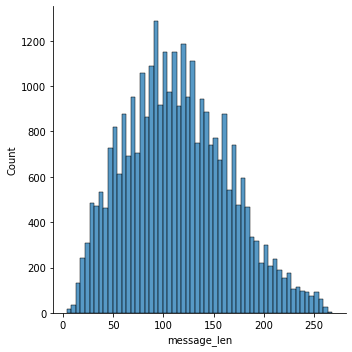

In [11]:
sns.displot( df , x= "message_len" );

In [12]:
df.head()

,message,originalClassification,scoreP,scoreZ,polarity,termsP,termsN,message_len
0,the rock is destined to be the 21st century's ...,POS,0.0,0.0,Inconclusive,NaN,NaN,177
1,"the gorgeously elaborate continuation of "" the...",POS,0.0,0.0,Inconclusive,NaN,NaN,226
2,effective but too-tepid biopic,POS,0.0,0.0,Inconclusive,NaN,NaN,30
3,if you sometimes like to go to the movies to h...,POS,0.0,0.0,Inconclusive,NaN,NaN,89
4,"emerges as something rare , an issue movie tha...",POS,0.0,0.0,Inconclusive,NaN,NaN,111


In [13]:
df.originalClassification.value_counts()

NEG    15993
POS    15993
Name: originalClassification, dtype: int64

In [14]:
df.polarity.value_counts()

Inconclusive        26108
Positive Extreme     5596
Negative Extreme      282
Name: polarity, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


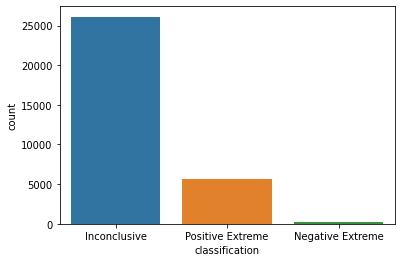

In [15]:
sns.countplot(df.polarity)
plt.xlabel('classification');

In [16]:
df['label'] = pd.factorize(df['polarity'])[0]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


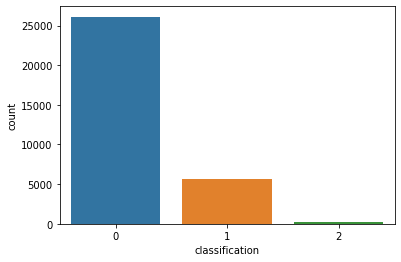

In [17]:
sns.countplot(df.label)
plt.xlabel('classification');

In [18]:
df['label'] = pd.factorize(df['polarity'])[0]

In [19]:
# Class count
count_class_0, count_class_1,count_class_2 = df.polarity.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
df_class_2 = df[df['label'] == 2]

In [20]:
df_class_2_over = pd.concat([df_class_2]*20, ignore_index=False)

In [21]:
df_class_2_over

,message,originalClassification,scoreP,scoreZ,polarity,termsP,termsN,message_len,label
27,an idealistic love story that brings out the l...,POS,0.0,0.97,Negative Extreme,NaN,latent,86,2
97,writer-director burger imaginatively fans the ...,POS,0.0,1.00,Negative Extreme,NaN,grief,146,2
137,gloriously goofy ( and gory ) midnight movie s...,POS,0.0,0.94,Negative Extreme,NaN,gory,52,2
233,denis and co-writer michele petin's impeccable...,POS,0.0,0.95,Negative Extreme,NaN,impeccable,201,2
266,"an incendiary , deeply thought-provoking look ...",POS,0.0,0.98,Negative Extreme,NaN,incendiary,153,2
...,...,...,...,...,...,...,...,...,...
10495,it's really just another silly hollywood actio...,NEG,0.0,0.96,Negative Extreme,NaN,silly,119,2
10542,"…the story is far-flung , illogical , and plai...",NEG,0.0,0.93,Negative Extreme,NaN,stupid,56,2
10598,you cannot guess why the cast and crew didn't ...,NEG,0.0,0.93,Negative Extreme,NaN,negative,137,2
10618,any film that doesn't even in passing mention ...,NEG,0.0,0.97,Negative Extreme,NaN,poverty,219,2


Random over-sampling:
Negative Extreme    5596
Positive Extreme    5596
Inconclusive        5596
Name: polarity, dtype: int64


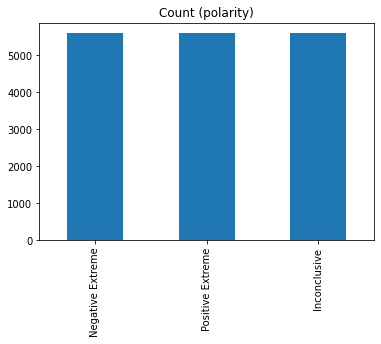

In [22]:
df_class_0_under = df_class_0.sample(count_class_1)
df_class_2_over = df_class_2.sample(n=5596, replace=True)

df_test_over = pd.concat([df_class_1, df_class_0_under,df_class_2_over], axis=0)

print('Random over-sampling:')
print(df_test_over.polarity.value_counts())

df_test_overdf_test_over.polarity.value_counts().plot(kind='bar', title='Count (polarity)');

In [70]:
test_df_rest =pd.merge(df,df_test_over, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [71]:
test_df_rest.label.value_counts()

0    12678
Name: label, dtype: int64

In [72]:
test_df_rest = pd.concat([test_df_rest, df_class_1,df_class_2], axis=0)

In [73]:
test_df_rest.label.value_counts()

0    12678
1     5596
2      282
Name: label, dtype: int64

In [27]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [28]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [29]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [30]:
encoding = tokenizer.encode_plus(
sample_txt,
max_length=32,           # sequence length
add_special_tokens=True, # Add '[CLS]' and '[SEP]'
return_token_type_ids=False,
padding='max_length',
return_attention_mask=True,
return_tensors='pt',  # Return PyTorch tensors(use tf for tensorflow and keras)
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [31]:
token_lens = []
for txt in df.message:
  tokens = tokenizer.encode(txt, truncation=True)
  token_lens.append(len(tokens))

In [32]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


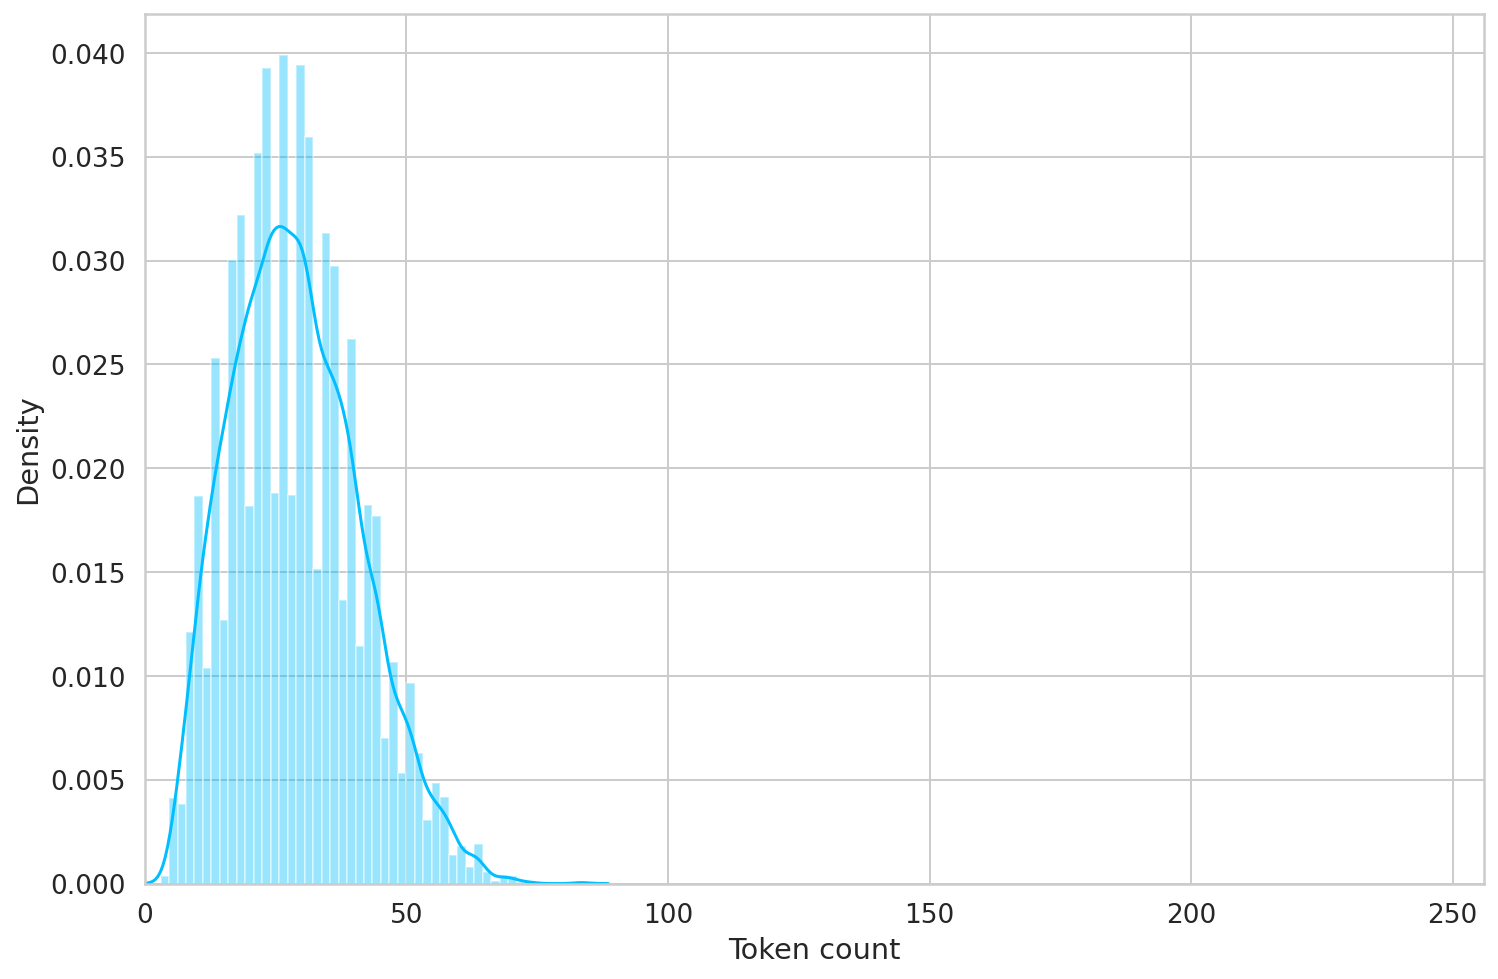

In [33]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [34]:
MAX_LEN = 90

In [35]:
class ExtremsSentiDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):

    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [36]:
df_train, df_test = train_test_split(
  df_test_over,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [37]:
df_train.shape, df_val.shape, df_test.shape

((13430, 9), (1679, 9), (1679, 9))

In [38]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ExtremsSentiDataset(
    reviews=df.message.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
rest_df = pd.merge(a,b, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [ ]:
#rest_test = df1['Email'].isin(df2['Email'])
#df1.drop(df1[cond].index, inplace = True)

In [74]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
all_test_data_loader = create_data_loader(test_df_rest, tokenizer, MAX_LEN, BATCH_SIZE)

In [40]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [42]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict=False
)

In [43]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [44]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [45]:
bert_model.config.hidden_size

768

In [46]:
pooled_output.shape

torch.Size([1, 768])

In [47]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [48]:
class_names = ["Inconclusive","Positive Extreme","Negative Extreme"]

In [49]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [50]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 90])
torch.Size([16, 90])


In [51]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4044, 0.1871, 0.4085],
        [0.4987, 0.1452, 0.3561],
        [0.2771, 0.1597, 0.5632],
        [0.5013, 0.1429, 0.3557],
        [0.5853, 0.1751, 0.2396],
        [0.3465, 0.1582, 0.4953],
        [0.4053, 0.1530, 0.4417],
        [0.3155, 0.2781, 0.4065],
        [0.3281, 0.1658, 0.5061],
        [0.2692, 0.2162, 0.5146],
        [0.4251, 0.1559, 0.4190],
        [0.4256, 0.2046, 0.3698],
        [0.5506, 0.0813, 0.3681],
        [0.4941, 0.1441, 0.3618],
        [0.3980, 0.1767, 0.4254],
        [0.3749, 0.1965, 0.4286]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [52]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.45627013824081847 accuracy 0.8175725986597171
Val   loss 0.23234413550013588 accuracy 0.9326980345443717

Epoch 2/10
----------
Train loss 0.1814330510276791 accuracy 0.950186150409531
Val   loss 0.18690529101129089 accuracy 0.9523525908278738

Epoch 3/10
----------
Train loss 0.1430551942867515 accuracy 0.9620253164556963
Val   loss 0.15866826798412062 accuracy 0.9583085169743896

Epoch 4/10
----------
Train loss 0.13114961613402037 accuracy 0.9642591213700671
Val   loss 0.16053591986142454 accuracy 0.9600952948183443

Epoch 5/10
----------
Train loss 0.1256366976622736 accuracy 0.964854802680566
Val   loss 0.15207734275609255 accuracy 0.9612864800476475

Epoch 6/10
----------
Train loss 0.12546040204719508 accuracy 0.9650037230081907
Val   loss 0.15133400298655034 accuracy 0.9630732578916023

Epoch 7/10
----------
Train loss 0.12506964649933036 accuracy 0.9650037230081907
Val   loss 0.174538921511599 accuracy 0.9594997022036927

Epoch 8/10
---------

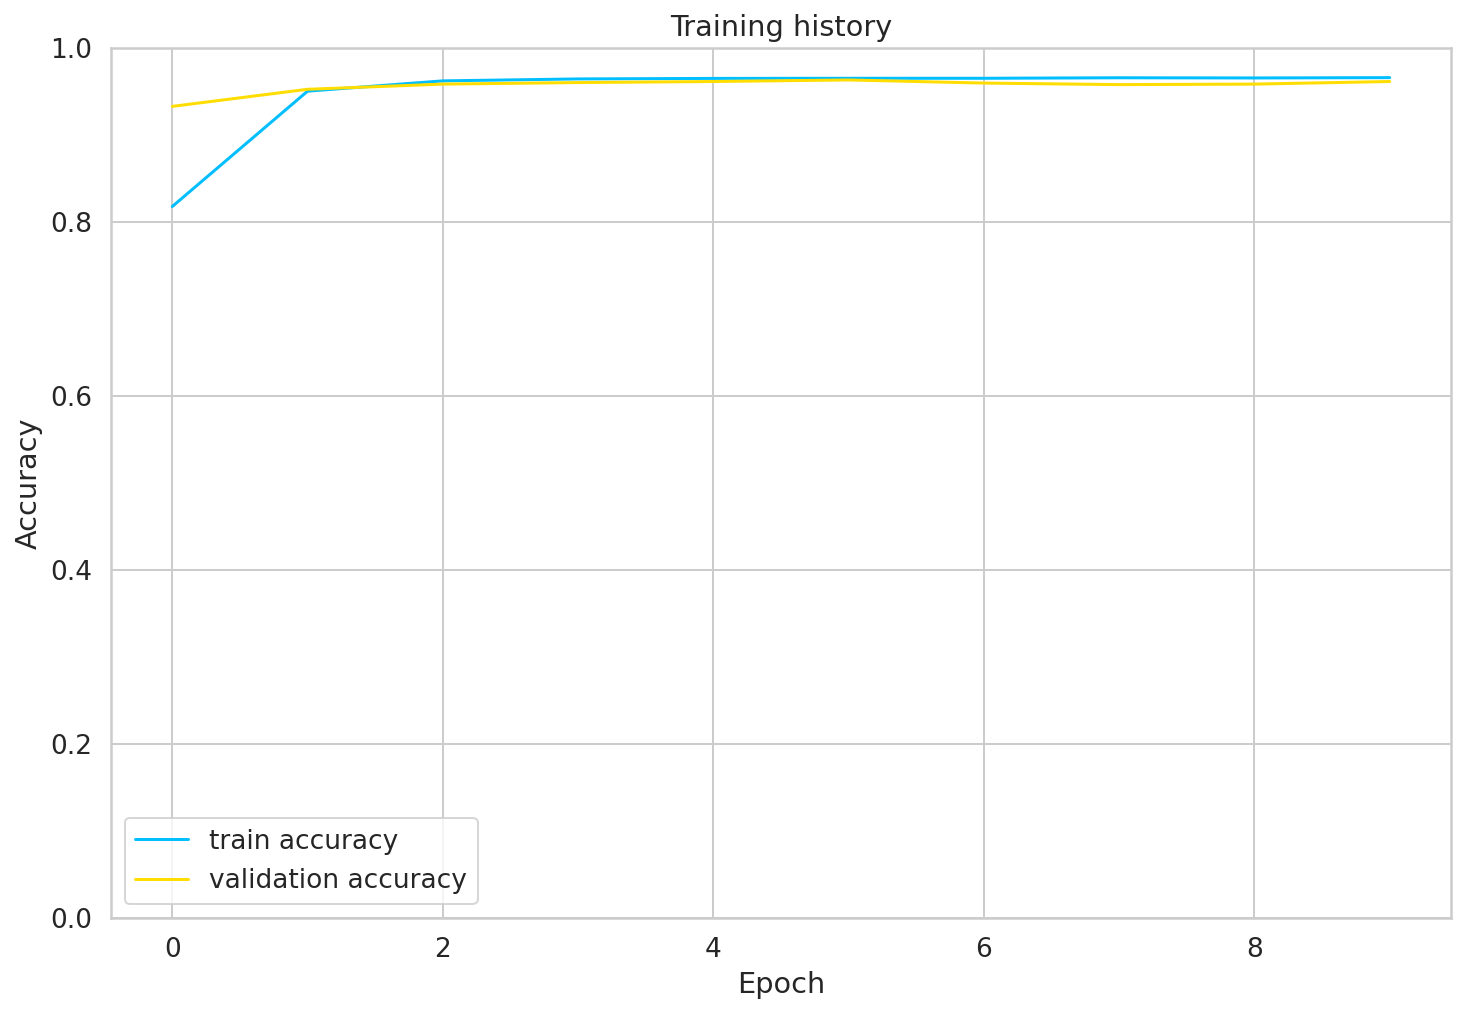

In [65]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [57]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df_rest)
)
test_acc.item()


0.12384259259259259

In [58]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [76]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  all_test_data_loader
)

In [77]:
print(classification_report(y_test, y_pred, target_names=class_names))


                  precision    recall  f1-score   support

    Inconclusive       1.00      0.98      0.99     12678
Positive Extreme       0.96      0.90      0.93      5596
Negative Extreme       0.30      1.00      0.46       282

        accuracy                           0.95     18556
       macro avg       0.75      0.96      0.79     18556
    weighted avg       0.98      0.95      0.96     18556



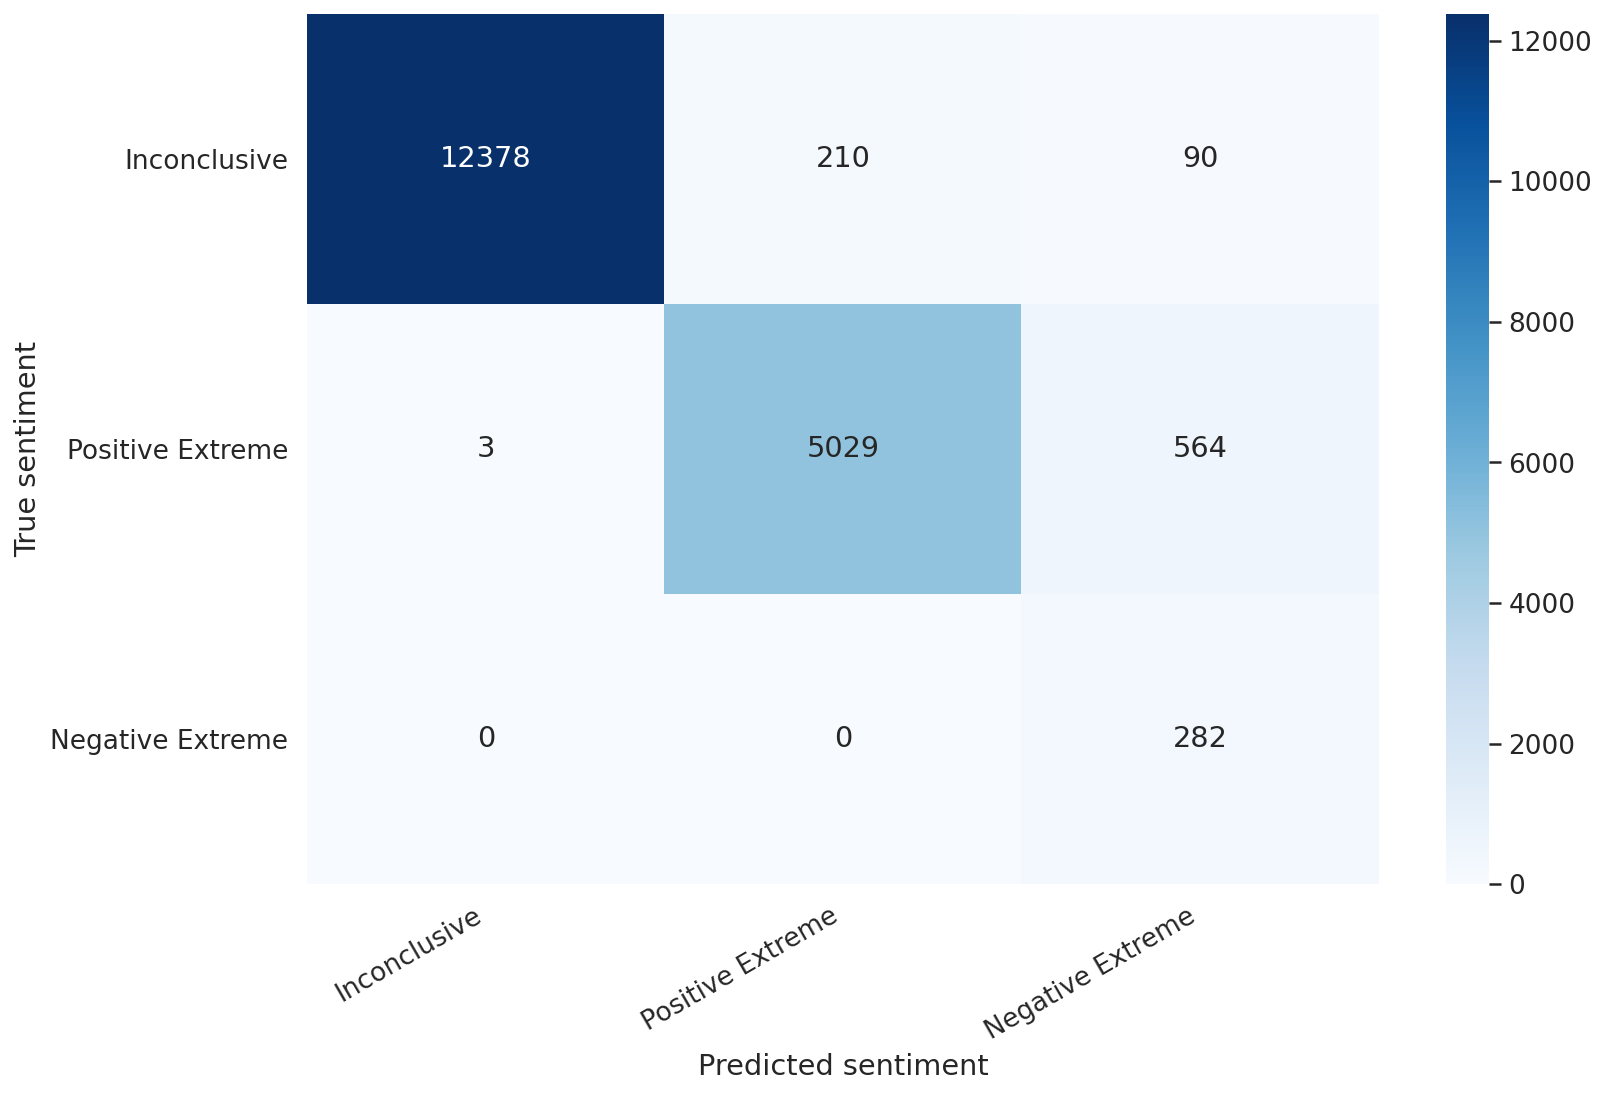

In [78]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [62]:
idx = 5
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [63]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

the acting , costumes , music , cinematography and sound are all
astounding given the production's austere locales .

True sentiment: Positive Extreme


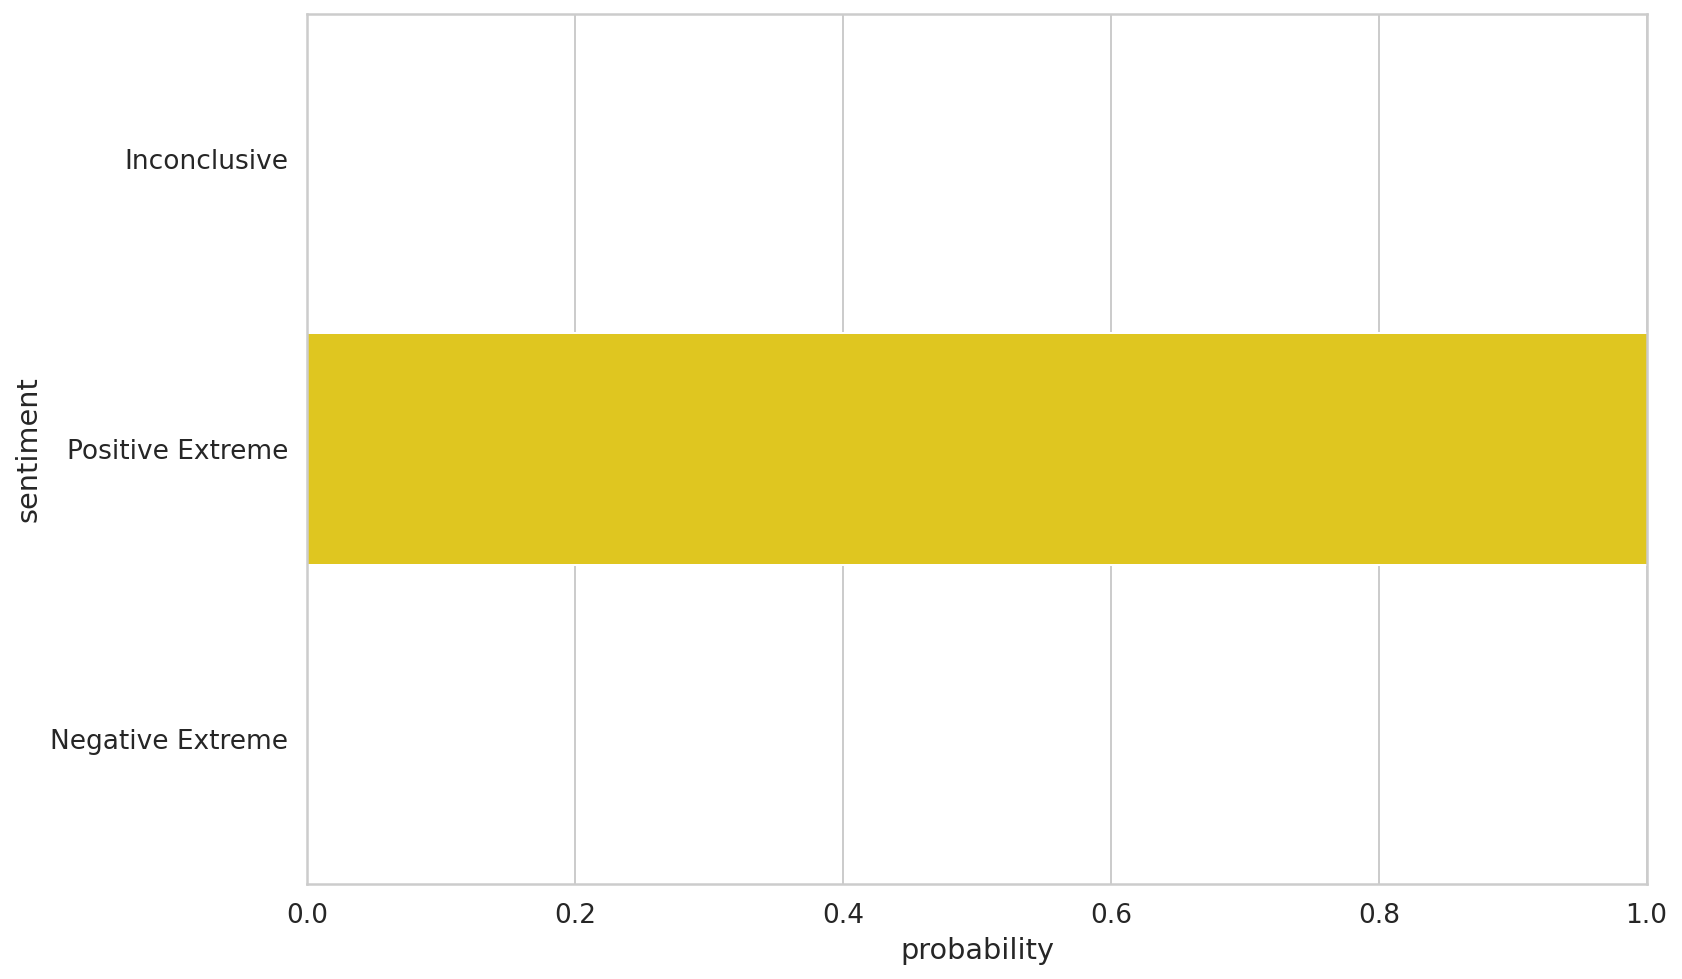

In [64]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);